Import Required Libraries

In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import geopandas as gpd
import matplotlib.colors as mcolors
import matplotlib.ticker as ticker
import plotly.express as px
import plotly.graph_objects as go
import datetime
from sklearn.cluster import KMeans
from matplotlib.font_manager import FontProperties
from IPython.display import HTML as html_print
from termcolor import colored
from scipy import stats
import warnings
import plotly.graph_objects as go
from plotly.subplots import make_subplots

warnings.filterwarnings('ignore', category=FutureWarning)

Adjust Row Column Settings

In [ ]:
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

HDI Classification by Rank (2021)
HDI Group	Rank Range	Description
 –

*   Very High HDI	1 -66    Countries with top-tier
                           development across income, education, and health

*   High HDI	67 - 130	  Strong development but with    
                          some equity or access gaps

*   Medium HDI 131 - 186	Moderate development, often with
                          regional disparities

*   Low HDI	187 - 193	    Facing significant development
                          challenges

Divide HDI  rank into 4 groups as the Human Development Index (HDI) rank for 2021 is a measure of economic progress and a way to broadly categorize countries as developed, developing, or underdeveloped. HDI is a comprehensive indicator of human well-being, combining health, education, and living standards (GNI per capita).


In [ ]:
#Functions
def classify_rank(rank):
    if rank <= 66:
        return "Very High"
    elif rank >66 and rank <= 130:
        return "High"
    elif rank>130 and rank <= 186:
        return "Medium"
    elif rank > 186:
        return "Low"

Loading the Data Set

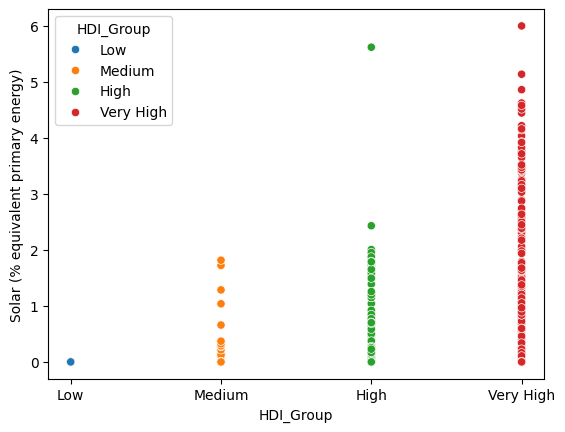

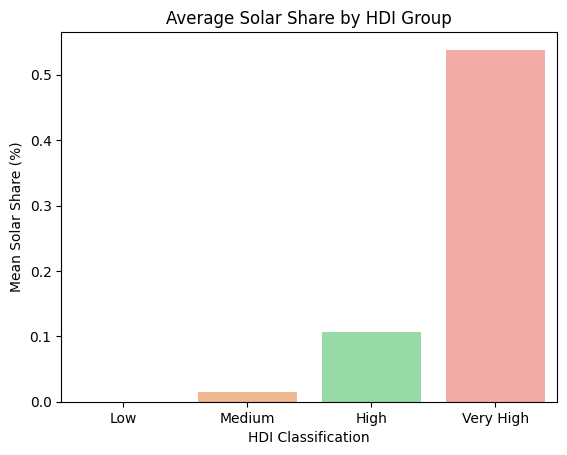

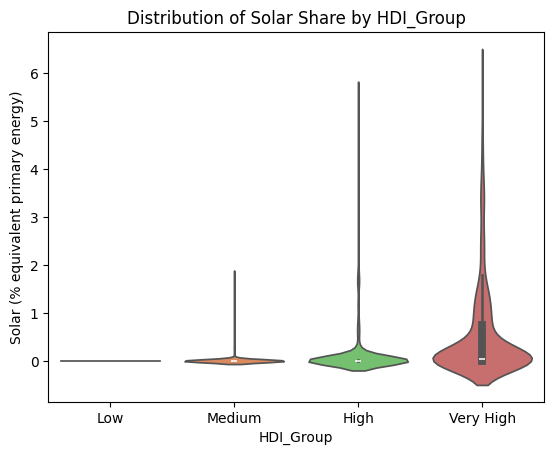

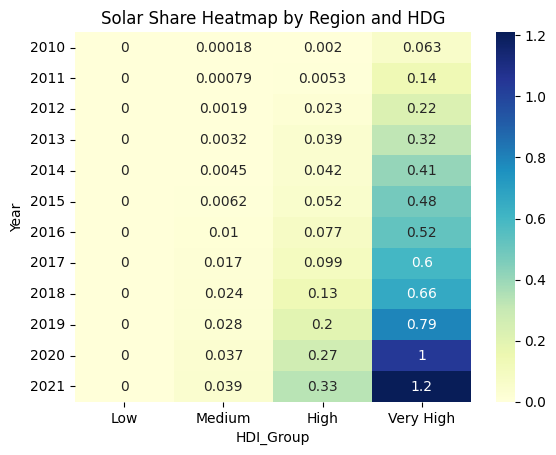

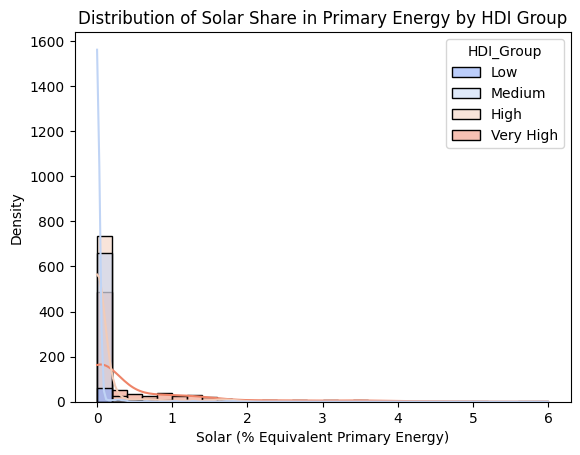

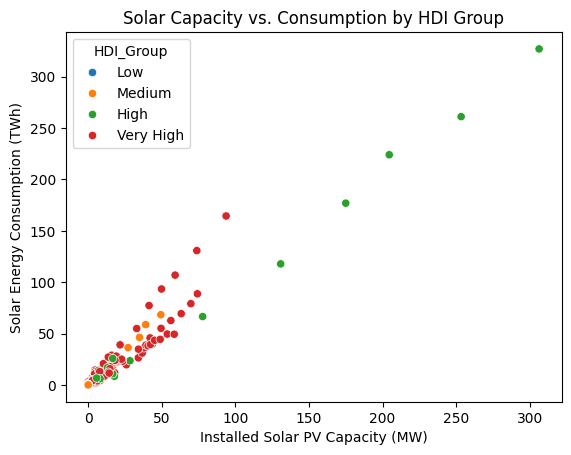

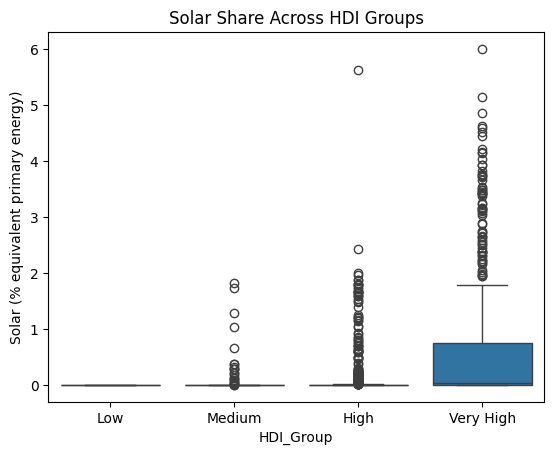

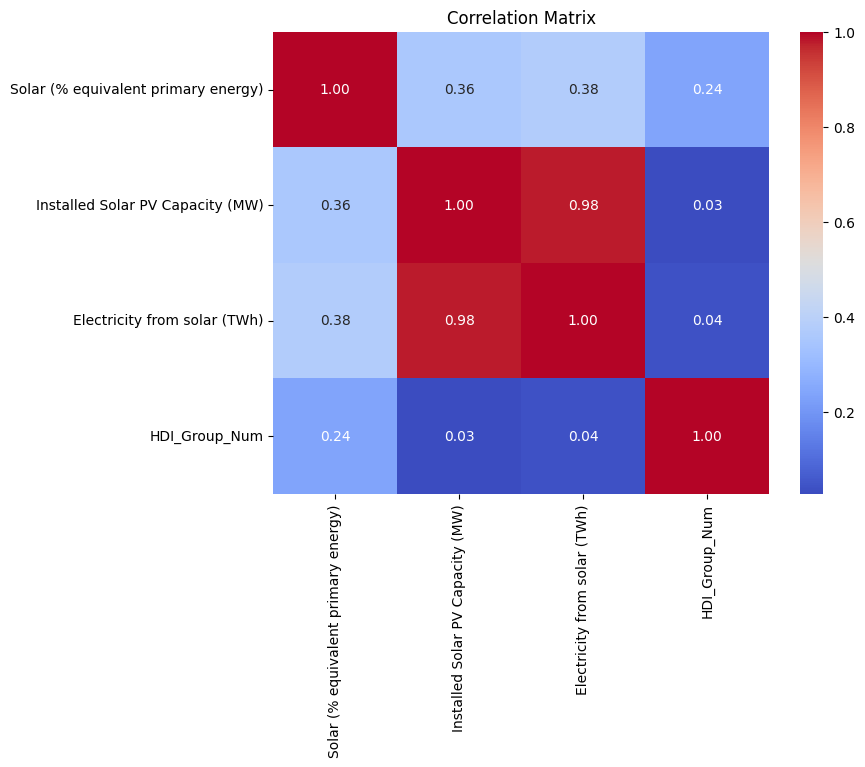

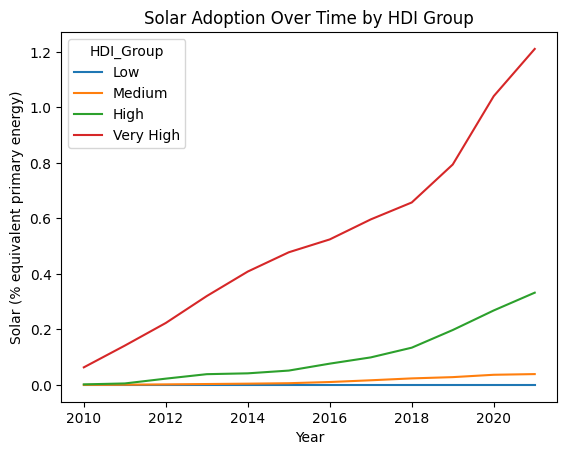

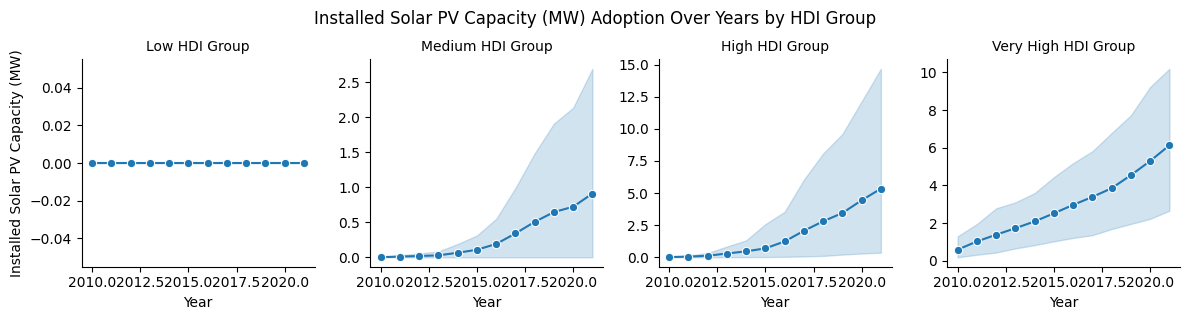

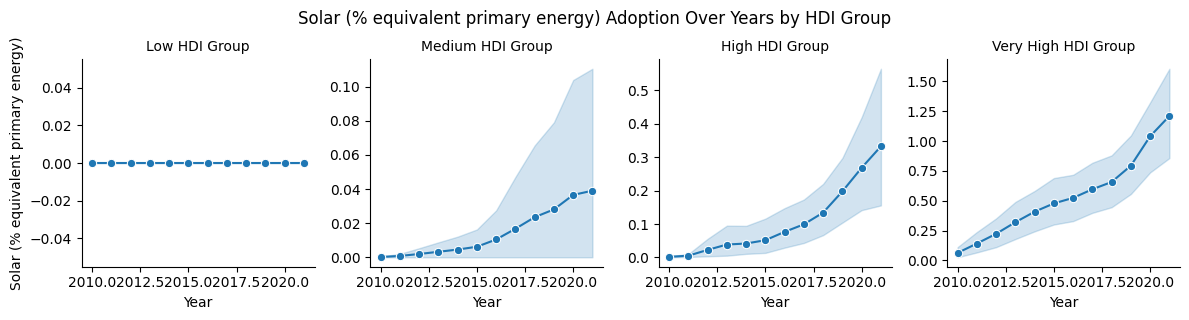

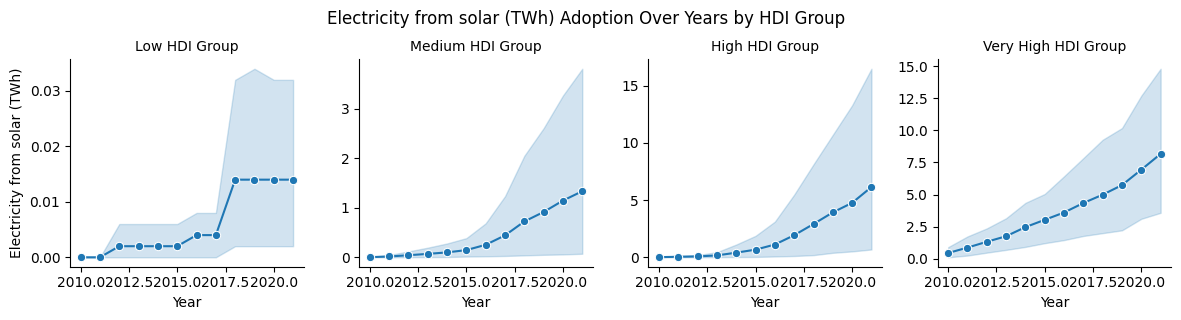

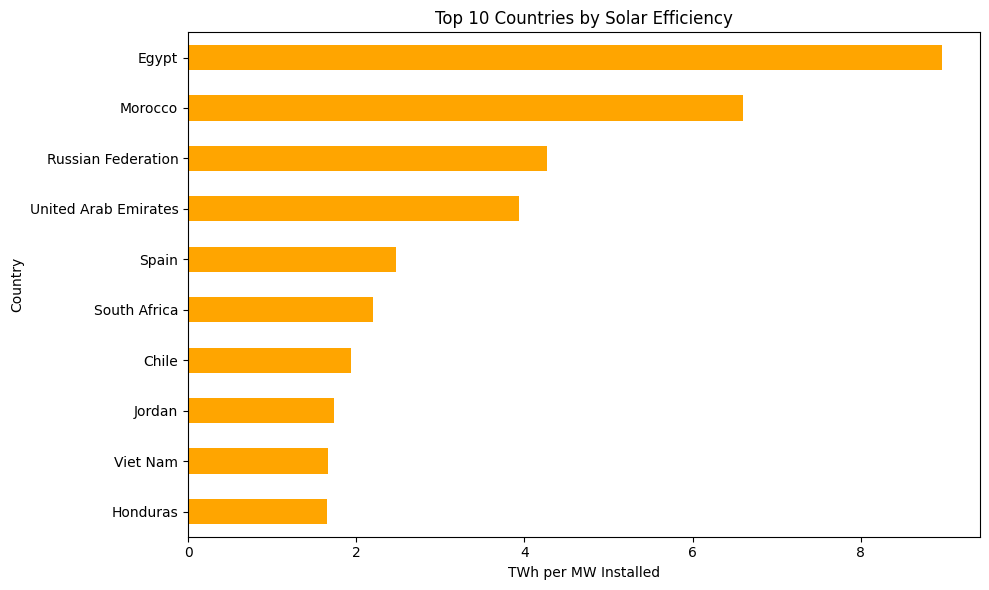

In [ ]:
# Define the custom order for HDI groups
hdi_order = ["Low", "Medium", "High", "Very High"]

# Drop rows with missing values in key columns before merge
#HDI Ranking using Inequality dataset
df_hdi = pd.read_csv("data/inequality-in-education.csv")
df_hdi_clean = df_hdi.dropna(subset=["ISO3", "Country","Year", "HDI Rank (2021)"])[["ISO3","Country", "Year", "HDI Rank (2021)"]]
# Rename 'iso3' to 'Code' in the inequality dataset
df_hdi_clean.rename(columns={"ISO3": "Code"}, inplace=True)
#Group the HDI Rank into 4 classifications
df_hdi_clean['HDI_Group'] = df_hdi_clean['HDI Rank (2021)'].apply(classify_rank)

#Solar data
#% of total primary energy from solar — solar’s role in national energy mix
df_solar_share = pd.read_csv("data/14 solar-share-energy.csv")
df_solar_share_clean = df_solar_share.dropna(subset=["Code", "Year", "Solar (% equivalent primary energy)"])[["Code", "Year", "Solar (% equivalent primary energy)"]]

#Installed solar PV capacity — infrastructure readiness
df_installed_capacity = pd.read_csv("data/13 installed-solar-PV-capacity.csv")
df_installed_capacity_clean = df_installed_capacity.dropna(subset=["Code", "Year", "Solar Capacity"])[["Code", "Year", "Solar Capacity"]]
df_installed_capacity_clean.rename(columns={"Solar Capacity": "Installed Solar PV Capacity (MW)"}, inplace=True)


#Total solar energy consumed — absolute solar uptake
df_solar_energy_consumption = pd.read_csv("data/12 solar-energy-consumption.csv")
df_solar_energy_consumption_clean = df_solar_energy_consumption.dropna(subset=["Code", "Year", "Electricity from solar (TWh)"])[["Code", "Year", "Electricity from solar (TWh)"]]
df_solar_energy_consumption_clean.rename(columns={"Electricity from solar (TWh)": "Solar Energy Consumption (TWh)"}, inplace=True)

#% of electricity from solar — grid-level solar penetration
df_solar_electricity_share = pd.read_csv("data/15 share-electricity-solar.csv")
df_solar_electricity_share_clean = df_solar_electricity_share.dropna(subset=["Code", "Year", "Solar (% electricity)"])[["Code", "Year", "Solar (% electricity)"]]

#Renewable dataset across broader range of renewables
#Electricity production from solar, wind, hydro, bioenergy — tech-level comparison
df_renewable_prod = pd.read_csv("data/03 modern-renewable-prod.csv")
df_renewable_prod_clean = df_renewable_prod.dropna(subset=["Code", "Year", "Electricity from wind (TWh)","Electricity from hydro (TWh)",
                                                           "Electricity from solar (TWh)","Other renewables including bioenergy (TWh)" ])[["Code", "Year", "Electricity from wind (TWh)","Electricity from hydro (TWh)","Electricity from solar (TWh)","Other renewables including bioenergy (TWh)" ]]

#% of total primary energy from all renewables — baseline for energy transition
df_renewable_share = pd.read_csv("data/01 renewable-share-energy.csv")
df_renewable_share_clean = df_renewable_share.dropna(subset=["Code", "Year", "Renewables (% equivalent primary energy)"])[["Code", "Year", "Renewables (% equivalent primary energy)"]]

#Total consumption of modern renewables (solar, wind, etc.) — absolute scale
df_modern_renewable_consumption = pd.read_csv("data/02 modern-renewable-energy-consumption.csv")
df_modern_renewable_consumption_clean = df_modern_renewable_consumption.dropna(subset=["Code", "Year", "Geo Biomass Other - TWh","Solar Generation - TWh","Wind Generation - TWh","Hydro Generation - TWh"])[["Code", "Year", "Geo Biomass Other - TWh","Solar Generation - TWh","Wind Generation - TWh","Hydro Generation - TWh"]]

#% of electricity generated from renewables — grid-level penetration
df_share_electricity_renewables = pd.read_csv("data/04 share-electricity-renewables.csv")
df_share_electricity_renewables_clean = df_share_electricity_renewables.dropna(subset=["Code", "Year", "Renewables (% electricity)"])[["Code", "Year", "Renewables (% electricity)"]]


# Merge on ISO3 code and year
# Start with solar share and HDI
merged_df = pd.merge(df_hdi_clean,df_solar_share_clean, on=["Code", "Year"], how="left")

# Add installed capacity
merged_df = merged_df.merge(df_installed_capacity_clean, on=["Code", "Year"], how="left")

# Add solar consumption
merged_df = merged_df.merge(df_solar_energy_consumption_clean, on=["Code", "Year"], how="left")

# Add solar electricity share
merged_df = merged_df.merge(df_solar_electricity_share_clean, on=["Code", "Year"], how="left")

# Add renewable production
merged_df = merged_df.merge(df_renewable_prod_clean, on=["Code", "Year"], how="left")

# Add renewable share
merged_df = merged_df.merge(df_renewable_share_clean, on=["Code", "Year"], how="left")

# Add modern renewable consumption
merged_df = merged_df.merge(df_modern_renewable_consumption_clean, on=["Code", "Year"], how="left")

# Add share elestricity renewables
merged_df = merged_df.merge(df_share_electricity_renewables_clean, on=["Code", "Year"], how="left")

# Optional: drop any remaining NaNs post-merge
merged_df = merged_df.fillna(0)
#merged_df = merged_df.dropna()

# Preview
merged_df.head()
merged_df.to_csv('outputs/output.csv', index=False)

# Convert HDI_Group to ordered categorical
merged_df["HDI_Group"] = pd.Categorical(
    merged_df["HDI_Group"],
    categories=hdi_order,
    ordered=True
)

#Scatter plot to visualize relationship:
sns.scatterplot(data=merged_df, x="HDI_Group", y="Solar (% equivalent primary energy)", hue="HDI_Group")
plt.show()

#Bar plot
avg_solar = merged_df.groupby("HDI_Group")["Solar (% equivalent primary energy)"].mean().reset_index()
sns.barplot(data=avg_solar, x="HDI_Group", y="Solar (% equivalent primary energy)", palette="pastel", order=hdi_order)
plt.title("Average Solar Share by HDI Group")
plt.ylabel("Mean Solar Share (%)")
plt.xlabel("HDI Classification")
plt.show()

#Violin plot
sns.violinplot(data=merged_df, x="HDI_Group", y="Solar (% equivalent primary energy)", order=hdi_order, palette="muted")
plt.title("Distribution of Solar Share by HDI_Group")
plt.show()

#Equity Heatmap
pivot = merged_df.pivot_table(
    index='Year',
    columns='HDI_Group',
    values='Solar (% equivalent primary energy)',
    aggfunc='mean'
)

sns.heatmap(pivot, annot=True, cmap='YlGnBu')
plt.title('Solar Share Heatmap by Region and HDG')
plt.show()

#Univariate Analysis
#📈 Solar Share Distribution
# Plot histogram with ordered categories
sns.histplot(
    data=merged_df,
    x="Solar (% equivalent primary energy)",  # Numeric axis
    hue="HDI_Group",                          # Grouping
    bins=30,
    kde=True,
    hue_order=hdi_order,
    palette="coolwarm"
)

plt.title("Distribution of Solar Share in Primary Energy by HDI Group")
plt.xlabel("Solar (% Equivalent Primary Energy)")
plt.ylabel("Density")
plt.show()

#📊 Installed Capacity vs. Consumption
sns.scatterplot(data=merged_df, x='Installed Solar PV Capacity (MW)', y='Solar Energy Consumption (TWh)', hue='HDI_Group')
plt.title('Solar Capacity vs. Consumption by HDI Group')
plt.show()

#Bivariate & Grouped Analysis
#🌍 Solar Share by HDI Group
sns.boxplot(data=merged_df, x='HDI_Group', y='Solar (% equivalent primary energy)', order=hdi_order)
plt.title('Solar Share Across HDI Groups')
plt.show()

#🔄 Correlation Matrix
from sklearn.preprocessing import LabelEncoder
# Convert HDI_Group strings into numeric values
le = LabelEncoder()
merged_df['HDI_Group_Num'] = le.fit_transform(merged_df['HDI_Group'])

# Now calculate correlation
corr = merged_df[['Solar (% equivalent primary energy)',
                  'Installed Solar PV Capacity (MW)',
                  'Electricity from solar (TWh)',
                  'HDI_Group_Num']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

#Time Series Trends
#Track solar adoption over time by HDI tier.
solar_trend = merged_df.groupby(['Year', 'HDI_Group'])['Solar (% equivalent primary energy)'].mean().reset_index()
sns.lineplot(data=solar_trend, x='Year', y='Solar (% equivalent primary energy)', hue='HDI_Group')
plt.title('Solar Adoption Over Time by HDI Group')
plt.show()

#Affordability & Policy Simulation
#💡 K-Means Clustering: Solar Readiness
from sklearn.cluster import KMeans
features = merged_df[['Installed Solar PV Capacity (MW)', 'Solar (% equivalent primary energy)', 'HDI_Group_Num']]
kmeans = KMeans(n_clusters=4).fit(features)
merged_df['Cluster'] = kmeans.labels_

#Geospatial Mapping
import plotly.express as px
fig = px.scatter_geo(merged_df, locations="Code", color="HDI_Group",
                     size="Solar (% equivalent primary energy)",
                     hover_name="Country", projection="natural earth")
fig.update_layout(title="Global Solar Share by HDI Group")
fig.show()

# Geospatial scatter plot
fig = px.scatter_geo(
    merged_df,
    locations="Code",                # Country codes
    color="HDI_Group",               # Color by HDI group (categorical)
    size="Electricity from solar (TWh)", # Bubble size: solar production
    hover_name="Country",
    hover_data={
        "Installed Solar PV Capacity (MW)": True,
        "Solar (% equivalent primary energy)": True,
        "Electricity from solar (TWh)": True
    },
    category_orders={"HDI_Group": hdi_order},  # Ensures color order
    projection="natural earth",
    template="plotly_white"
)

fig.update_layout(
    title="Global Solar Production vs Installed Capacity by HDI Group"
)
fig.show()


# Metrics to plot
metrics = ["Installed Solar PV Capacity (MW)",
           "Solar (% equivalent primary energy)",
           "Electricity from solar (TWh)"]

for metric in metrics:
    g = sns.FacetGrid(merged_df, col="HDI_Group", col_order=hdi_order, sharey=False)
    g.map_dataframe(sns.lineplot, x="Year", y=metric, marker="o")
    g.set_titles("{col_name} HDI Group")
    g.set_axis_labels("Year", metric)
    g.fig.suptitle(f"{metric} Adoption Over Years by HDI Group", y=1.05)
    plt.show()



# Melt dataframe for multi-metric interactive plotting (optional)
fig = px.line(
    merged_df,
    x="Year",
    y="Installed Solar PV Capacity (MW)",  # Change to other metrics as needed
    color="HDI_Group",
    category_orders={"HDI_Group": hdi_order},
    markers=True,
    title="Installed Solar PV Capacity Over Years by HDI Group"
)

fig.show()



# Create subplots: 1 row, 3 columns
fig = make_subplots(
    rows=1, cols=3,
    shared_yaxes=False,
    subplot_titles=metrics
)

# Assign a color for each HDI group
colors = px.colors.qualitative.Set1

for i, metric in enumerate(metrics):
    for j, hdi in enumerate(hdi_order):
        df_hdi = merged_df[merged_df["HDI_Group"] == hdi]
        fig.add_trace(
            go.Scatter(
                x=df_hdi["Year"],
                y=df_hdi[metric],
                mode="lines+markers",
                name=hdi if i == 0 else None,  # Only show legend once
                line=dict(color=colors[j]),
                marker=dict(size=6)
            ),
            row=1,
            col=i+1
        )

# Update layout
fig.update_layout(
    title_text="Solar Adoption Metrics Over Years by HDI Quartiles",
    legend_title="HDI Group",
    width=1800,
    height=500
)

fig.update_xaxes(title_text="Year", row=1, col=1)
fig.update_xaxes(title_text="Year", row=1, col=2)
fig.update_xaxes(title_text="Year", row=1, col=3)

fig.update_yaxes(title_text="Installed PV (MW)", row=1, col=1)
fig.update_yaxes(title_text="Solar Share (%)", row=1, col=2)
fig.update_yaxes(title_text="Solar Production (TWh)", row=1, col=3)

fig.show()

colors = px.colors.qualitative.Set1
metrics = ["Installed Solar PV Capacity (MW)",
           "Solar (% equivalent primary energy)",
           "Electricity from solar (TWh)"]

# Create figure with 3 subplots
fig = make_subplots(
    rows=1, cols=3,
    shared_yaxes=True,
    subplot_titles=metrics
)

# Compute relative growth per HDI group
merged_df = merged_df.sort_values(["HDI_Group", "Year"])
for metric in metrics:
    merged_df[f"{metric}_growth"] = merged_df.groupby("HDI_Group")[metric].pct_change() * 100

# Plot lines and growth shading
for i, metric in enumerate(metrics):
    for j, hdi in enumerate(hdi_order):
        df_hdi = merged_df[merged_df["HDI_Group"] == hdi]


# Comparison of Electricity generation from various renewable sources
renewable_cols = ["Electricity from wind (TWh)",
                  "Electricity from hydro (TWh)",
                  "Electricity from solar (TWh)",
                  "Other renewables including bioenergy (TWh)",
                  "Geo Biomass Other - TWh"]

df_long = merged_df.melt(
    id_vars=["Year", "HDI_Group"],
    value_vars=renewable_cols,
    var_name="Renewable_Type",
    value_name="Electricity_TWh"
)

df_long["HDI_Group"] = pd.Categorical(df_long["HDI_Group"],
                                      categories=hdi_order,
                                      ordered=True)

fig = px.bar(
    df_long,
    x="Year",
    y="Electricity_TWh",
    color="Renewable_Type",
    barmode="stack",  # Stacks values on top of each other
    facet_col="HDI_Group",
    category_orders={"HDI_Group": hdi_order},
    title="Stacked Renewable Electricity Generation by Year and HDI Group"
)

fig.update_yaxes(title_text="Renewable Electricity Used (TWh)")
fig.update_xaxes(title_text="Year")
fig.show()


# Comparison of Electricity used from various renewable sources
renewable_cols = ["Solar Generation - TWh",
                  "Wind Generation - TWh",
                  "Hydro Generation - TWh",
                  "Geo Biomass Other - TWh"]

df_long = merged_df.melt(
    id_vars=["Year", "HDI_Group"],
    value_vars=renewable_cols,
    var_name="Renewable_Type",
    value_name="Electricity_TWh"
)

# Plot with Plotly Express
fig = px.bar(
    df_long,
    x="Year",
    y="Electricity_TWh",
    color="Renewable_Type",
    barmode="stack",  # Stacks values on top of each other
    facet_col="HDI_Group",
    category_orders={"HDI_Group": hdi_order},
    title="Stacked Renewable Electricity Used by Year and HDI Group"
)

fig.update_yaxes(title_text="Renewable Electricity Used (TWh)")
fig.update_xaxes(title_text="Year")
fig.show()




# Comparison of Electricity generation from various renewable sources
renewable_cols = ["Solar Generation - TWh",
                  "Wind Generation - TWh",
                  "Hydro Generation - TWh",
                  "Geo Biomass Other - TWh"]

df_long = merged_df.melt(
    id_vars=["Year", "HDI_Group"],
    value_vars=renewable_cols,
    var_name="Renewable_Type",
    value_name="Electricity_TWh"
)

# Plot with Plotly Express
fig = px.bar(
    df_long,
    x="Year",
    y="Electricity_TWh",
    color="Renewable_Type",
    barmode="stack",  # Stacks values on top of each other
    facet_col="HDI_Group",
    category_orders={"HDI_Group": hdi_order},
    title="Stacked Renewable Electricity Used by Year and HDI Group"
)

fig.update_yaxes(title_text="Renewable Electricity Used (TWh)")
fig.update_xaxes(title_text="Year")
fig.show()




# Comparison of solar statistics - Installed solar vs consumption
renewable_cols = ["Installed Solar PV Capacity (MW)",
                  "Solar Energy Consumption (TWh)"]


df_long = merged_df.melt(
    id_vars=["Year", "HDI_Group"],
    value_vars=renewable_cols,
    var_name="Renewable_Type",
    value_name="Electricity_TWh"
)

# Plot with Plotly Express
fig = px.bar(
    df_long,
    x="Year",
    y="Electricity_TWh",
    color="Renewable_Type",
    barmode="group",  # Stacks values on top of each other
    facet_col="HDI_Group",
    category_orders={"HDI_Group": hdi_order},
    title="Solar statistics by Year and HDI Group"
)

fig.update_yaxes(title_text="Installed solar vs consumption")
fig.update_xaxes(title_text="Year")
fig.show()


# Comparison of solar statistics
renewable_cols = ["Solar (% equivalent primary energy)",
                  "Solar (% electricity)"]
# Loop over each HDI group and plot separately
for hdi in hdi_order:
    df_hdi = df_long[df_long["HDI_Group"] == hdi]

    fig = px.bar(
        df_hdi,
        x="Year",
        y="Electricity_TWh",
        color="Renewable_Type",
        barmode="group",      # bars next to each other
        title=f"Renewable Electricity by Year - {hdi} HDI Group",
        text="Electricity_TWh" # optional: show values on bars
    )

    fig.update_yaxes(title_text="Solar's share in primary vs Grid Level penetration", showgrid=True)
    fig.update_xaxes(title_text="Year", tickmode="linear", dtick=1)
    fig.update_layout(bargap=0.2, bargroupgap=0.1)

    fig.show()


# 🧮 Calculate solar efficiency (TWh per MW)
merged_df = merged_df[merged_df["Installed Solar PV Capacity (MW)"] > 0]  # Avoid division by zero
merged_df["Efficiency_TWh_per_MW"] = merged_df["Solar Energy Consumption (TWh)"] / merged_df["Installed Solar PV Capacity (MW)"]

# 📊 Plot 1: Scatter plot of Consumption vs Capacity
fig1 = px.scatter(
    merged_df,
    x="Installed Solar PV Capacity (MW)",
    y="Solar Energy Consumption (TWh)",
    color="Country",
    size="Efficiency_TWh_per_MW",
    hover_name="Country",
    title="Solar Consumption vs Installed Capacity"
)
fig1.show()

# 📊 Plot 2: Top 10 countries by average solar efficiency
top_eff = merged_df.groupby("Country")["Efficiency_TWh_per_MW"].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
top_eff.plot(kind="barh", color="orange")
plt.xlabel("TWh per MW Installed")
plt.title("Top 10 Countries by Solar Efficiency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Solar equity analysis displayed as  a strategic simulation and dashboard that shows how interventions like community microleasing could transform solar adoption in underperforming regions.

In [ ]:
#Part 1: Annotate Underperforming Regions
#🔍 Identify Underperformers
#This should capture countries with significant infrastructure but low utilization.
threshold_capacity = merged_df["Installed Solar PV Capacity (MW)"].quantile(0.5)

#This flags countries with low integration of solar into their energy mix, despite capacity.
threshold_share = merged_df["Solar (% equivalent primary energy)"].quantile(0.4)


underperformers = merged_df[
    (merged_df["Installed Solar PV Capacity (MW)"] > threshold_capacity) &
    (merged_df["Solar (% equivalent primary energy)"] < threshold_share) &
    (merged_df["HDI_Group"].isin(["Low", "Medium"]))]

underperformers = merged_df[
    (merged_df["Installed Solar PV Capacity (MW)"] > threshold_capacity) &
    (merged_df["Solar (% equivalent primary energy)"] < threshold_share)]


fig = px.scatter(
    merged_df,
    x="Installed Solar PV Capacity (MW)",
    y="Solar Energy Consumption (TWh)",
    color="HDI_Group",
    hover_name="Country",
    title="Solar Consumption vs Capacity with Underperformers Highlighted"
)

# Add annotations
for country in underperformers["Country"]:
    fig.add_annotation(text=country, x=underperformers.loc[underperformers["Country"] == country, "Installed Solar PV Capacity (MW)"].values[0],
                       y=underperformers.loc[underperformers["Country"] == country, "Solar Energy Consumption (TWh)"].values[0],
                       showarrow=True, arrowhead=1)
fig.show()

#Part 2: Simulate Microleasing Impact
#Assume Microleasing increases solar share by 10–30% in underperforming regions
#It improves efficiency (TWh per MW) by 15–25% due to better utilization

# Simulate impact
solar_boost = 1.3  # 30% increase
efficiency_boost = 1.25  # 25% increase

underperformers["Simulated Solar Share (%)"] = underperformers["Solar (% equivalent primary energy)"] * solar_boost
underperformers["Simulated Efficiency"] = underperformers["Efficiency_TWh_per_MW"] * efficiency_boost

fig.update_layout(yaxis=dict(range=[0, 5]))  # Adjust based on your data

#Part 3: Solar Justice KPI Dashboard
#Key Metrics to Track
#Solar Share (%)
#Installed Capacity (MW)
#Efficiency (TWh/MW)
#HDI Group
#Simulated Solar Share
#Simulated Efficiency

kpi_df = underperformers[[
    "Country", "HDI_Group", "Installed Solar PV Capacity (MW)",
    "Solar (% equivalent primary energy)", "Efficiency_TWh_per_MW",
    "Simulated Solar Share (%)", "Simulated Efficiency"
]]

kpi_df = kpi_df.sort_values("Solar (% equivalent primary energy)", ascending=True)
kpi_df["Solar Share Δ (%)"] = kpi_df["Simulated Solar Share (%)"] - kpi_df["Solar (% equivalent primary energy)"]
kpi_df["Efficiency Δ"] = kpi_df["Simulated Efficiency"] - kpi_df["Efficiency_TWh_per_MW"]

fig = px.bar(
    kpi_df,
    x="Country",
    y=["Solar (% equivalent primary energy)", "Simulated Solar Share (%)"],
    barmode="group",
    title="Solar Share Before and After Microleasing Simulation"
)
fig.update_layout(yaxis=dict(range=[0, 5]))  # Adjust based on your data
fig.show()

fig2 = px.bar(
    underperformers,
    x="Country",
    y=["Efficiency_TWh_per_MW", "Simulated Efficiency"],
    barmode="group",
    title="Efficiency Before and After Microleasing Simulation"
)
fig2.update_layout(yaxis_title="Efficiency (TWh/MW)", xaxis_title="Country")
fig2.show()



/tmp/ipython-input-1954637538.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-1954637538.py:45: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Visualizing Solar Equity Flows by HDI Group using a Sankey diagram

In [ ]:
# 📦 Step 1: Install & Import Libraries
import pandas as pd
import plotly.graph_objects as go

# 🧭 Step 3: Define Nodes
nodes = [
    "Installed Capacity", "Solar Share", "Solar Consumption",
    "Very High HDI", "High HDI", "Medium HDI", "Low HDI"
]
node_indices = {name: i for i, name in enumerate(nodes)}

# 🔗 Step 4: Create Flows
links = {
    'source': [],
    'target': [],
    'value': [],
    'label': []
}

# Capacity → Share
for _, row in merged_df.iterrows():
    links['source'].append(node_indices["Installed Capacity"])
    links['target'].append(node_indices["Solar Share"])
    links['value'].append(row['Installed Solar PV Capacity (MW)'])
    links['label'].append(f"{row['HDI_Group']} Capacity")

# Share → Consumption
for _, row in merged_df.iterrows():
    links['source'].append(node_indices["Solar Share"])
    links['target'].append(node_indices["Solar Consumption"])
    links['value'].append(row['Solar (% equivalent primary energy)'])
    links['label'].append(f"{row['HDI_Group']} Share")

# Consumption → HDI Group
for _, row in merged_df.iterrows():
    links['source'].append(node_indices["Solar Consumption"])
    links['target'].append(node_indices[f"{row['HDI_Group']} HDI"])
    links['value'].append(row['Solar Energy Consumption (TWh)'])
    links['label'].append(f"{row['HDI_Group']} Consumption")

# 🎨 Step 5: Build Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="lightblue"
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value'],
        label=links['label']
    )
)])

fig.update_layout(title_text="Solar Energy Flow by HDI Group", font_size=12)
fig.show()

# 📦 Step 1: Import Libraries
import pandas as pd
import plotly.graph_objects as go

# 📊 Step 2: Aggregate Data by HDI Group
solar_df = merged_df.groupby('HDI_Group').agg({
    'Installed Solar PV Capacity (MW)': 'sum',
    'Solar (% equivalent primary energy)': 'mean',
    'Solar Energy Consumption (TWh)': 'sum'
}).reset_index()

# 🧭 Step 3: Define Nodes
nodes = [
    "Installed Capacity", "Solar Share", "Solar Consumption",
    "Very High HDI", "High HDI", "Medium HDI", "Low HDI"
]
node_indices = {name: i for i, name in enumerate(nodes)}

# 🔗 Step 4: Create Flows
links = {'source': [], 'target': [], 'value': [], 'label': []}

# Capacity → Share
for _, row in solar_df.iterrows():
    links['source'].append(node_indices["Installed Capacity"])
    links['target'].append(node_indices["Solar Share"])
    links['value'].append(row["Installed Solar PV Capacity (MW)"])
    links['label'].append(f"{row['HDI_Group']} Capacity")

# Share → Consumption
for _, row in solar_df.iterrows():
    links['source'].append(node_indices["Solar Share"])
    links['target'].append(node_indices["Solar Consumption"])
    links['value'].append(row["Solar (% equivalent primary energy)"])
    links['label'].append(f"{row['HDI_Group']} Share")

# Consumption → HDI Group
for _, row in solar_df.iterrows():
    links['source'].append(node_indices["Solar Consumption"])
    links['target'].append(node_indices[f"{row['HDI_Group']} HDI"])
    links['value'].append(row["Solar Energy Consumption (TWh)"])
    links['label'].append(f"{row['HDI_Group']} Consumption")

# 🎨 Step 5: Build Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="lightblue"
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value'],
        label=links['label']
    )
)])

fig.update_layout(title_text="Solar Energy Flow by HDI Group", font_size=12)
fig.show()

# 📦 Step 1: Import Libraries
import pandas as pd
import plotly.graph_objects as go

# 📊 Step 2: Calculate Efficiency
merged_df = merged_df[merged_df["Installed Solar PV Capacity (MW)"] > 0]
merged_df["Efficiency_TWh_per_MW"] = merged_df["Solar Energy Consumption (TWh)"] / merged_df["Installed Solar PV Capacity (MW)"]

# 🔍 Step 3: Identify Underperformers
threshold_capacity = merged_df["Installed Solar PV Capacity (MW)"].quantile(0.5)
threshold_share = merged_df["Solar (% equivalent primary energy)"].quantile(0.4)
underperformers = merged_df[
    (merged_df["Installed Solar PV Capacity (MW)"] > threshold_capacity) &
    (merged_df["Solar (% equivalent primary energy)"] < threshold_share)
]

# 🔧 Step 4: Simulate Microleasing Impact
solar_boost = 1.3  # +30% share
efficiency_boost = 1.25  # +25% efficiency
underperformers["Simulated Solar Share (%)"] = underperformers["Solar (% equivalent primary energy)"] * solar_boost
underperformers["Simulated Efficiency"] = underperformers["Efficiency_TWh_per_MW"] * efficiency_boost

# 🧭 Step 5: Define Nodes
nodes = [
    "Installed Capacity", "Solar Share", "Solar Consumption",
    "Simulated Share", "Simulated Consumption",
    "Very High HDI", "High HDI", "Medium HDI", "Low HDI"
]
node_indices = {name: i for i, name in enumerate(nodes)}

# 🔗 Step 6: Create Flows
links = {'source': [], 'target': [], 'value': [], 'label': []}

# Actual Flows
for _, row in underperformers.iterrows():
    hdi = row["HDI_Group"]
    links['source'].append(node_indices["Installed Capacity"])
    links['target'].append(node_indices["Solar Share"])
    links['value'].append(row["Installed Solar PV Capacity (MW)"])
    links['label'].append(f"{row['Country']} Actual Capacity")

    links['source'].append(node_indices["Solar Share"])
    links['target'].append(node_indices["Solar Consumption"])
    links['value'].append(row["Solar (% equivalent primary energy)"])
    links['label'].append(f"{row['Country']} Actual Share")

    links['source'].append(node_indices["Solar Consumption"])
    links['target'].append(node_indices[f"{hdi} HDI"])
    links['value'].append(row["Solar Energy Consumption (TWh)"])
    links['label'].append(f"{row['Country']} Actual Consumption")

# Simulated Flows
for _, row in underperformers.iterrows():
    hdi = row["HDI_Group"]
    links['source'].append(node_indices["Installed Capacity"])
    links['target'].append(node_indices["Simulated Share"])
    links['value'].append(row["Installed Solar PV Capacity (MW)"])
    links['label'].append(f"{row['Country']} Simulated Capacity")

    links['source'].append(node_indices["Simulated Share"])
    links['target'].append(node_indices["Simulated Consumption"])
    links['value'].append(row["Simulated Solar Share (%)"])
    links['label'].append(f"{row['Country']} Simulated Share")

    links['source'].append(node_indices["Simulated Consumption"])
    links['target'].append(node_indices[f"{hdi} HDI"])
    links['value'].append(row["Simulated Efficiency"] * row["Installed Solar PV Capacity (MW)"])
    links['label'].append(f"{row['Country']} Simulated Consumption")

# 🎨 Step 7: Build Sankey Diagram
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,
        thickness=20,
        line=dict(color="black", width=0.5),
        label=nodes,
        color="lightblue"
    ),
    link=dict(
        source=links['source'],
        target=links['target'],
        value=links['value'],
        label=links['label']
    )
)])

fig.update_layout(title_text="Solar Equity Flow: Actual vs Simulated Microleasing Impact", font_size=12)
fig.show()



/tmp/ipython-input-2927667944.py:142: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipython-input-2927667944.py:143: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

